In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib

%run './../split_step_fourier.ipynb'

DEBUG = False

# showing figures inline
%matplotlib inline
# plotting options 
font = {'size': 12}
figure_size = (25, 15)
plt.rc('font', **font)
plt.rc('text', usetex=True)

In [2]:
# parameters
f_symbol = 32e9  # symbol rate (Baud) (Symbols per second)
n_up = 10  # samples per symbol (>1 => oversampling)

r_rc = .33
syms_per_filt = 4  # symbols per filter (plus minus in both directions)
t_sample_rc, rc = get_rc_ir(syms_per_filt, r_rc, f_symbol, n_up)

P_in = 5 # dBm

# modulation scheme and constellation points
M = 2
modulation = {'0': -1, '1': 1}
n_symbol = 30 # number of symbols


# Signalfolge generieren
send_bits = np.random.choice([symbol for symbol in modulation.keys()], size=n_symbol)


# Sendesignal generieren
send_rc = generate_signal(modulation, t_sample_rc, 1/f_symbol, send_bits, rc, syms_per_filt)

# add zeros before and after signal (use samples per symbol as factor)
send = zeroing(send_rc, 80 * int(1/f_symbol/t_sample_rc))

In [3]:
## Transmission parameters
full_distance = 800

z_length = 70  # [km]
nz = 7  # steps
dz = z_length / nz  # [km]

alpha = 0.2  # Dämpfung [dB/km]
D = 17  # [ps/nm/km]
beta2 = - (D * np.square(1550e-9)) / (2 * np.pi * 3e8) * 1e-3 # [s^2/km] propagation constant, lambda=1550nm is standard single-mode wavelength
gamma = 1.3 # [1/W/km]

In [4]:
# init arrays for plotting with values at 0 input
power_full_distance = [np.power(10, (P_in-30)/10)]
xvals_full_distance = [0.0]

# put an amplifier every z_length km in the fiber
next_input = amplifier(send, P_in, t_sample_rc, 1/f_symbol)

for segment in range(int(full_distance / z_length)):
    segment_output = splitstepfourier(next_input, t_sample_rc, dz, nz, alpha, beta2, gamma, True)
    segment_power = [np.real(calc_power(val, t_sample_rc, 1/f_symbol)) for val in segment_output.values()]
    segment_xvals = [float(key)*dz + segment * z_length for key in segment_output.keys()]
    
    if DEBUG:
        print(f"Segment {segment} power values: {segment_power}")
        fig = plt.figure()
        plt.plot(segment_output[f"{str(nz)}"])

    next_input = amplifier(segment_output[f"{str(nz)}"], P_in, t_sample_rc, 1/f_symbol)    
    
    power_full_distance += segment_power
    xvals_full_distance += segment_xvals
    
    if segment is not int(full_distance/z_length)-1:
        power_full_distance += [np.real(calc_power(next_input, t_sample_rc, 1/f_symbol))]
        xvals_full_distance += [(segment+1.0)*z_length]

if full_distance % z_length != 0:
    power_full_distance += [np.real(calc_power(next_input, t_sample_rc, 1/f_symbol))]
    xvals_full_distance += [(segment+1.0)*z_length]
    
    rest_z_length = full_distance % z_length
    rest_dz = rest_z_length / nz
    rest_output = splitstepfourier(next_input, t_sample_rc, rest_dz, nz, alpha, beta2, gamma, True)
    rest_power = [np.real(calc_power(val, t_sample_rc , 1/f_symbol)) for val in segment_output.values()]
    rest_xvals = [float(key)*rest_dz + int(full_distance / z_length) * z_length for key in segment_output.keys()]
    
    power_full_distance += rest_power
    xvals_full_distance += rest_xvals

/home/dominik/.virtualenvs/jupyterlab/lib/python3.7/site-packages/ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part


(0, 0.0033203914117005645)

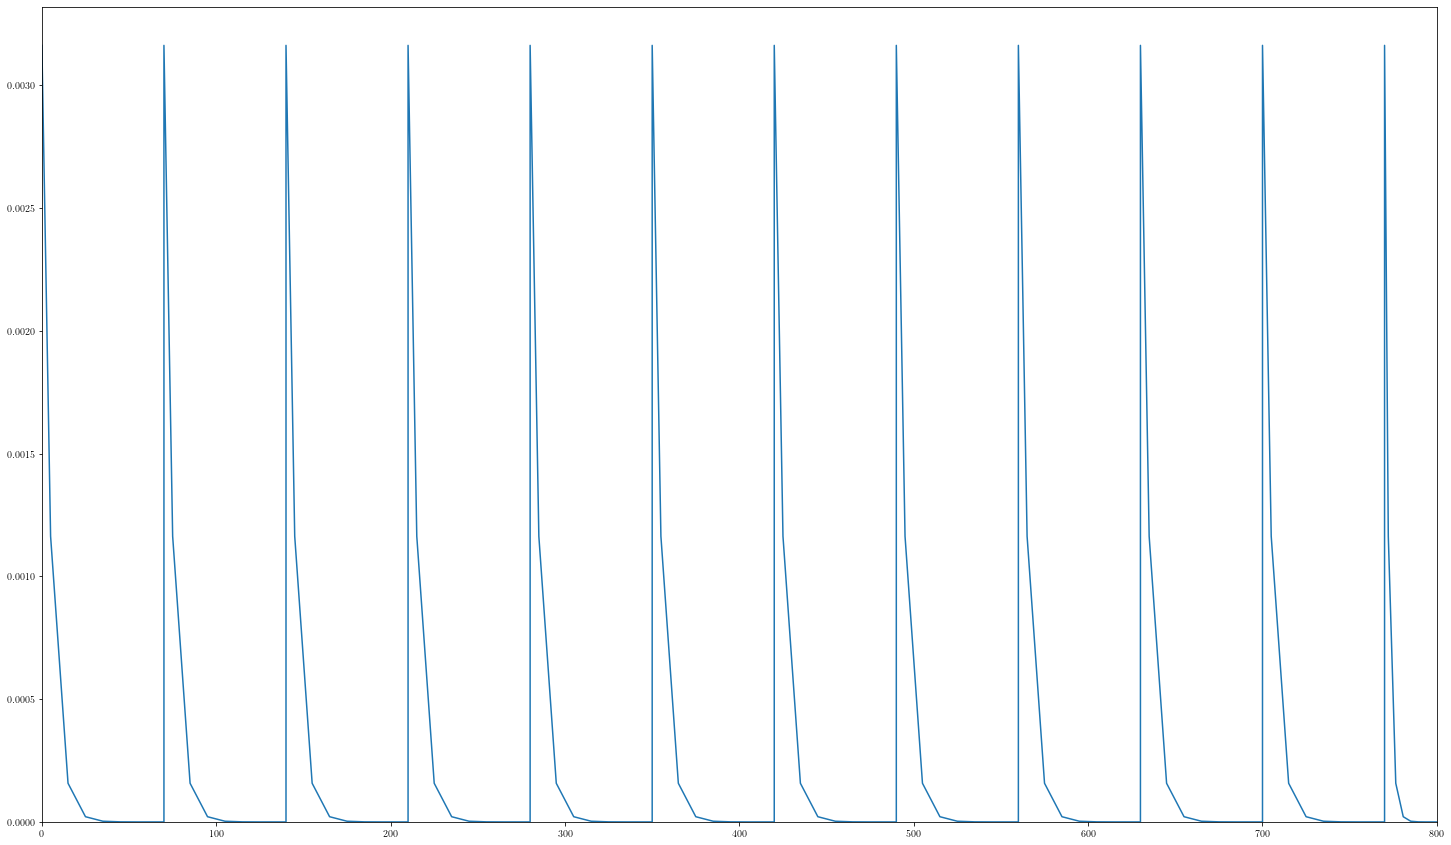

In [5]:
fig1, ax1 = plt.subplots(1, figsize=figure_size, sharex=True)

ax1.plot(xvals_full_distance, power_full_distance)
ax1.set_xlim(np.amin(xvals_full_distance), np.amax(xvals_full_distance))
ax1.set_ylim(bottom=0)

In [6]:
tikzplotlib.save('../../../bachelorarbeit-ausarbeitung/figures/plots/long_distance_power_level.tex', figure=fig1)